In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/polyu')

Mounted at /content/drive


In [2]:
!pip install tensorflow-ranking
import tensorflow_ranking as tfr
# import tensorflow as tf
from tensorflow.python.keras.initializers import Identity, glorot_uniform, Zeros
from tensorflow.python.keras.layers import Dropout, Input, Layer, Embedding, Reshape
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.regularizers import l2
# from tensorflow.python.keras.optimizers import adam_v2
from tqdm import tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfull

In [3]:
!/opt/bin/nvidia-smi

Fri Jan 27 08:38:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Data Propcessing**


**input** **data**

In [ ]:
import os
import os.path as osp
import shutil
import torch
from tqdm import tqdm

shutil.copy("/content/drive/MyDrive/polyu/waitingT_hk_duration_100.zip", "/content")
!unzip waitingT_hk_duration_100.zip

root = '/content/waitingT_hk_duration_100'
# normalize the duration time to (0,1)
x0 = []
x = []
y = []
num_time = len(os.listdir(root))
for i in tqdm(range(num_time)):

  datai = torch.load(osp.join(root, '%d.pt'%i))

  x0i = datai[5,:]
  xi = datai[:5,:]
  yi = datai[6,:]

  x0.append(x0i)
  x.append(xi)
  y.append(yi)

x0_in_memory = torch.stack(x0,axis=1).float()
x_in_memory = torch.stack(x,axis=1).float()
y_in_memory = torch.stack(y,axis=1).float()

print("x0_in_memory shape: ", x0_in_memory.shape)
print("x_in_memory shape: ", x_in_memory.shape)
print("y_in_memory shape: ", y_in_memory.shape)

In [ ]:
print("x0_in_memory shape: ", x0_in_memory.shape)
print("x_in_memory shape: ", x_in_memory.shape)
print("y_in_memory shape: ", y_in_memory.shape)

x0_in_memory shape:  torch.Size([48, 29000])
x_in_memory shape:  torch.Size([5, 29000, 48])
y_in_memory shape:  torch.Size([48, 29000])



find the max min of x

In [ ]:
# hkall = torch.load('/content/drive/MyDrive/polyu/hkall.pt') # hk_island's O/V time(not duration)
# print(hkall.shape)
# num_node, num_time = hkall.shape



# def find_max_min(data):

#   num_node, num_time = data.shape

#   num_node, num_time = data.shape
#   maxmin = torch.zeros(num_node,2)

#   for i in tqdm(range(num_node)):
#     dur_list = []
#     datab = data[i,0]
#     count = 1

#     for j in range(1, num_time):
#       dataa = data[i,j]
  
#       if datab == dataa:
#         count = count + 1
#         if j == num_time-1:
#           dur_list.append(count)
#       else:
#         dur_list.append(count)
#         count = 1
#       datab = dataa

#     maxmin[i,0] = max(dur_list)
#     maxmin[i,1] = min(dur_list)

#   return maxmin,dur_list

# graph_maxmin,_ = find_max_min(hkall)
# print(graph_maxmin.shape)

torch.Size([48, 31000])


100%|██████████| 48/48 [00:12<00:00,  3.74it/s]

torch.Size([48, 2])


data_normalization

In [5]:
#x0_scale
x0_scale = x0_in_memory.T
x0_scale = torch.stack([x0_scale], axis=2)
#x_scale
# x_scale = torch.zeros_like(x_in_memory)
# for i in range(x_in_memory.shape[0]):
#   x_in_memoryi = x_in_memory[i,:,:]
#   # xup = torch.sub(abs(x_in_memoryi), graph_maxmin[:,1].T) * (x_in_memoryi / abs(x_in_memoryi))
#   # xdown = (graph_maxmin[:,0]-graph_maxmin[:,1]).T
#   mean =  x_in_memoryi.mean(dim=0)
#   std = x_in_memoryi.std(dim=0)
#   xup = torch.sub(x_in_memoryi, mean)
#   # x_scale[i,:,:] = torch.div(xup, std)
#   x_scale[i,:,:] = (x_in_memoryi - mean)/std
x_scale = torch.tanh(x_in_memory) 
#y_scale
# y_scale=y_in_memory.T
# minmax:
yup = torch.sub(y_in_memory.T, torch.min(y_in_memory)) # 分子
ydown = (torch.max(y_in_memory)-torch.min(y_in_memory)).T # 分母
y_scale = torch.div(yup, ydown)

# y_scale = torch.exp(y_in_memory)
# y_scale = y_scale.T

print("x0_scale shape: ", x0_scale.shape)
print("x_scale shape: ", x_scale.shape)
print("y_scale shape: ", y_scale.shape)

x0_scale shape:  torch.Size([29000, 48, 1])
x_scale shape:  torch.Size([5, 29000, 48])
y_scale shape:  torch.Size([29000, 48])


In [ ]:
y_scale[1]

tensor([0.0000, 0.0101, 0.4495, 0.4444, 0.4697, 0.2020, 0.6212, 0.6212, 0.4747,
        0.2929, 0.4899, 0.5253, 0.5253, 1.0000, 0.5455, 0.7121, 0.4697, 0.5152,
        0.5859, 0.4848, 0.4596, 0.5051, 0.5051, 0.4949, 0.5101, 1.0000, 0.5051,
        0.4242, 0.0000, 1.0000, 1.0000, 0.5909, 0.5202, 0.8081, 0.0000, 0.0000,
        0.6364, 0.4444, 0.4040, 0.5404, 1.0000, 1.0000, 0.5303, 0.7071, 0.6212,
        0.5051, 0.5152, 0.3333])

Adjacent Matrix Building

In [6]:
import scipy.sparse as sp
import numpy as np
## part 1: spatial adjacent matrix building using GCN's method

def preprocess_adj(adj, symmetric=True):

    adj = adj + sp.eye(adj.shape[0])

    return adj

def node_deg(adj):

  adj = preprocess_adj(adj)

  deg = adj.sum(axis=0)

  return deg


def aggregating_gcn(adj, method = "both"):

  if method == "both":

    adj = preprocess_adj(adj)

    degs = node_deg(adj)

    # print(degs.shape)

    adj_c = np.zeros_like(adj)

    for i in range(adj.shape[0]):

      for j in range(adj.shape[1]):

        norm = pow(degs[0,i] * degs[0,j], -0.5)

        # print(norm.dtype)

        adj_c[i, j] = norm

    adj_c = np.multiply(adj_c, adj)

  return adj_c
#part 2: add event information to the above adjacnt matrix

A = torch.load('/content/drive/MyDrive/polyu/meter_link/link_49_hk_diag.pt')

adj_c = aggregating_gcn(A) 

adj_c = adj_c.astype(np.float32)

x_f = x_scale.numpy()
adj = []
for i in range(max(x_f.shape)):
  adj_f = x_f[:,i,:].T
  adj.append(np.hstack((adj_c, adj_f)))
Adj = np.array(adj)

print("Adj_shape: ", Adj.shape)

Adj_shape:  (29000, 48, 53)


In [ ]:
Adj.shape

(29000, 48, 51)

rank label building——matrix

In [ ]:
# A = torch.load('/content/drive/MyDrive/polyu/meter_link/link_49_hk_diag.pt')

# A = torch.from_numpy(preprocess_adj(A)).float()

# Y = torch.zeros((max(y_scale.shape), A.shape[0], A.shape[1]))

# for i in tqdm(range(max(y_scale.shape))):

#   # Y[i,:,:] = torch.mul(torch.from_numpy(A), y_scale[i,:]) 
#   Yi = torch.mul(y_scale[i,:], A) # y_sacle is a line, and it multiply each line of A

#   Y_sumi = torch.sum(Yi, dim=1, keepdim = True)

#   Y[i,:,:] = torch.div(Yi, Y_sumi)    # probability

# print('\n')
# print("label size: ", Y.shape)


100%|██████████| 29000/29000 [00:00<00:00, 37912.95it/s]



label size:  torch.Size([29000, 48, 48])


In [7]:
A = torch.load('/content/drive/MyDrive/polyu/meter_link/link_49_hk_diag.pt')

A = torch.from_numpy(preprocess_adj(A)).float()

Y = torch.zeros((max(y_scale.shape), A.shape[0], A.shape[1]))

for i in tqdm(range(max(y_scale.shape))):

  # Y[i,:,:] = torch.mul(torch.from_numpy(A), y_scale[i,:]) 
  Y[i,:,:] = torch.mul(y_scale[i,:], A) # y_sacle is a line, and it multiply each line of A

# softmax:
Fsoftmax=0
if Fsoftmax:
  softmax = torch.nn.Softmax(2)
  Y = softmax(Y)

# for i in tqdm(range(max(y_scale.shape))):

#   # Y[i,:,:] = torch.mul(torch.from_numpy(A), y_scale[i,:]) 
#   Y[i,:,:] = torch.mul(Y[i,:], A) # y_sacle is a line, and it multiply each line of A

print('\n')
print("label size: ", Y.shape)

100%|██████████| 29000/29000 [00:00<00:00, 61267.02it/s]



label size:  torch.Size([29000, 48, 48])


In [58]:
A.sum()

tensor(530.)

In [ ]:
torch.set_printoptions(threshold=torch.inf)
Y[2]

rank label building——line

In [ ]:
A2 = torch.load('/content/drive/MyDrive/polyu/meter_link/link_49_all_hk.pt')

Y2 = torch.zeros((max(y_scale.shape), max(A2.shape), 1))

for i in tqdm(range(max(y_scale.shape))):

  for j in range(max(A2.shape)):

    Y2[i, j, 0] = y_scale[i, A2[1, j]]

100%|██████████| 29000/29000 [02:43<00:00, 176.92it/s]


In [ ]:
torch.set_printoptions(threshold=torch.inf)
torch.sum(Y[11], dim=1, keepdim = True)

In [ ]:
y_scale.shape

torch.Size([29000, 48])

In [ ]:
np.set_printoptions(threshold=torch.inf)
A

## **Building Model**

network structure

In [95]:
import tensorflow as tf
from tensorflow.python.keras.initializers import Identity, glorot_uniform, Zeros
from tensorflow.python.keras.layers import Dropout, Input, Layer, Embedding, Reshape
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.regularizers import l2

def delta(x):

  return x + 0.01

class GraphConvolution(Layer):  # ReLU(AXW)

    def __init__(self, units, frequents,
                 activation=tf.nn.relu, dropout_rate=0.5,
                 use_bias=True, l2_reg=0,
                 seed=1024, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        self.freqs = frequents
        self.use_bias = use_bias
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.seed = seed

    def build(self, input_shapes):

        # print("ok")

        self.num_node = input_shapes[0][-2]
        # print(num_node)

        # print("ok")

        # feature_dim = input_shapes[0][-1]
        # print(feature_dim)

        self.kernel_loc = self.add_weight(shape=(self.num_node,
                                self.units),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel_loc', )
        
        self.kernal_freq = self.add_weight(shape=(self.num_node,
                                self.freqs),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernal_freq', )
        
        self.kernal_combine = self.add_weight(shape=(self.num_node,
                         self.units + self.freqs),
                         initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel_comb',)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.num_node, self.units),
                                        initializer=Zeros(),
                                        name='bias', )

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True

    def call(self, inputs, training=None, **kwargs):
        # feature_node, feature_edge, adj = inputs
        feature, adj = inputs
        adj_c = adj[:,:, :self.num_node]
        adj_f = adj[:,:, self.num_node:]
        print("real_time_state_shape: ", feature.shape)
        print("adj: ", adj.shape)
        print("spatial_adj: ", adj_c.shape)
        print("turn_over_event_adj: ", adj_f.shape)
        # graph_embedding = tf.divide(tf.matmul(feature_node, adj), tf.reduce_sum(adj,0))
        # node_edge = tf.concat([graph_embedding,feature_edge],0)
        feature_vertex = tf.matmul(adj_c, feature)
        print("feature_vertex: ", feature_vertex.shape)
        # print("feature_shape: ", feature.shape)
        # output = tf.reduce_sum(tf.multiply(feature, self.kernel),2)   
        output_vertex = tf.multiply(feature_vertex, self.kernel_loc)
        print("output_vertex: ", output_vertex.shape)

        output_edge = tf.multiply(adj_f, self.kernal_freq)
        # tf.keras.layers.Conv1D(self.num_node, 3, activation='relu', input_shape=input_shape[2:])(x)
        print("output_edge: ", output_edge.shape)

        output = tf.reduce_sum(tf.multiply(tf.concat([output_vertex, output_edge],-1), self.kernal_combine), -1, keepdims=True)
        print("output: ", output.shape) # output_shape = (None, 48, 1)

        if self.use_bias:
            output += self.bias
        print("output_shape: ",output.shape)
        act = self.activation(output)
        
        # print(" call ok")


        # act._uses_learning_phase = features._uses_learning_phase
        return act


    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                  'feature_less': self.feature_less,
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class ReadOut(Layer):

  ## this layer gives each list a line

    def __init__(self,
              activation=tf.nn.leaky_relu, dropout_rate=0.5,
              use_bias=True, l2_reg=0,
              seed=1024, **kwargs):
      super(ReadOut, self).__init__(**kwargs)
      self.use_bias = use_bias
      self.l2_reg = l2_reg
      self.dropout_rate = dropout_rate
      self.activation = activation
      self.seed = seed

    def build(self, input_shapes):

        # print("ok")

        self.num_node = input_shapes[0][-2]
        # print(num_node)

        # print("ok")

        # feature_dim = input_shapes[0][-1]
        # print(feature_dim)

        # self.kernel = self.add_weight(shape=(self.num_node * self.num_node,
        #                         self.num_node),
        #                 initializer=glorot_uniform(
        #                     seed=self.seed),
        #                 regularizer=l2(self.l2_reg),
        #                 name='kernel_loc', )

        self.kernel1 = self.add_weight(shape=(self.num_node,
                                self.num_node),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel_loc', )
        
        # self.kernel2 = self.add_weight(shape=(self.num_node,
        #                         self.num_node),
        #                 initializer=glorot_uniform(
        #                     seed=self.seed),
        #                 regularizer=l2(self.l2_reg),
        #                 name='kernel_loc', )

        

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.num_node, self.num_node),
                                        initializer=Zeros(),
                                        name='bias', )

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True

    def call(self, inputs, training=None, **kwargs):

        feature, adj = inputs

        adj_c = adj[:,:, :self.num_node]

        # output = tf.matmul(self.kernel, feature)

        output = tf.multiply(feature, self.kernel1)

        # output = tf.matmul(self.kernel2, output)

        output = tf.reshape(output,[-1, self.num_node, self.num_node])

        print("ReadOut2_output_shape: ",output.shape)

        if self.use_bias:
            output += self.bias

        act = self.activation(output) 

        # result = tf.multiply(act, adj_c)

        return act   

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                  'feature_less': self.feature_less,
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))  

class ReadOut2(Layer):

  ## this layer gives each list a line

    def __init__(self,
              activation=tf.nn.leaky_relu, dropout_rate=0.5,
              use_bias=True, l2_reg=0,
              seed=1024, **kwargs):
      super(ReadOut2, self).__init__(**kwargs)
      self.use_bias = use_bias
      self.l2_reg = l2_reg
      self.dropout_rate = dropout_rate
      self.activation = activation
      self.seed = seed

    def build(self, input_shapes):

        # print("ok")

        self.num_node = input_shapes[0][-2]
        # print(num_node)

        # print("ok")

        # feature_dim = input_shapes[0][-1]
        # print(feature_dim)

        # self.kernel = self.add_weight(shape=(self.num_node * self.num_node,
        #                         self.num_node),
        #                 initializer=glorot_uniform(
        #                     seed=self.seed),
        #                 regularizer=l2(self.l2_reg),
        #                 name='kernel_loc', )

        self.kernel1 = self.add_weight(shape=(self.num_node,
                                self.num_node),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel_loc', )
        
        # self.kernel2 = self.add_weight(shape=(self.num_node,
        #                         self.num_node),
        #                 initializer=glorot_uniform(
        #                     seed=self.seed),
        #                 regularizer=l2(self.l2_reg),
        #                 name='kernel_loc', )

        

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.num_node, self.num_node),
                                        initializer=Zeros(),
                                        name='bias', )

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True

    def call(self, inputs, training=None, **kwargs):

        feature, adj = inputs

        adj_c = adj[:,:, :self.num_node]

        # output = tf.matmul(self.kernel, feature)

        output = tf.multiply(feature, self.kernel1)

        # output = tf.matmul(self.kernel2, output)

        output = tf.reshape(output,[-1, self.num_node, self.num_node])

        print("ReadOut2_output_shape: ",output.shape)

        if self.use_bias:
            output += self.bias

        act = self.activation(output) 

        result = tf.multiply(act, adj_c)

        return result   

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                  'feature_less': self.feature_less,
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))  

class ReadOut3(Layer):

  ## this layer gives each list a line

    def __init__(self,
              activation=tf.nn.leaky_relu, dropout_rate=0.5,
              use_bias=True, l2_reg=0,
              seed=1024, **kwargs):
      super(ReadOut3, self).__init__(**kwargs)
      self.use_bias = use_bias
      self.l2_reg = l2_reg
      self.dropout_rate = dropout_rate
      self.activation = activation
      self.seed = seed

    def build(self, input_shapes):

        # print("ok")

        self.num_node = input_shapes[0][-2]
        # print(num_node)

        # print("ok")

        self.feature_dim = input_shapes[0][-1]

        self.feature0_dim = input_shapes[2][-1]

        self.adjmax = input_shapes[1][-1]
        # print(feature_dim)

        self.kernel = self.add_weight(shape=(self.num_node,
                                (self.feature0_dim+2*self.adjmax-2*self.num_node)),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel', )

        self.kernel1 = self.add_weight(shape=(self.num_node,
                                self.num_node),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel1', )
        
        self.kernel2 = self.add_weight(shape=(self.num_node,
                                self.num_node),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel2', )        
        
        # self.kernel3 = self.add_weight(shape=(self.num_node,
        #                         self.num_node),
        #                 initializer=glorot_uniform(
        #                     seed=self.seed),
        #                 regularizer=l2(self.l2_reg),
        #                 name='kernel2', )

        

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.num_node, self.num_node),
                                        initializer=Zeros(),
                                        name='bias', )

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True

    def call(self, inputs, training=None, **kwargs):

        feature, adj, feature0 = inputs

        adj_c = adj[:,:, :self.num_node]

        adj_f = adj[:,:, self.num_node:]

        # output = tf.matmul(self.kernel, feature)

        ## individual feature from Q and Z

        Q = tf.concat([feature0, abs(adj_f), tf.cast(adj_f>0, dtype = tf.float32)],-1) # [None, 48, 1+5+5]

        print("Q:", Q.shape)

        outputQ = tf.reduce_sum(tf.multiply(Q, self.kernel), -1, keepdims=True) # [None, 48, 1]

        print("outputQ:", outputQ.shape)

        outputZ = tf.reshape(feature,[-1,1,self.num_node])   # [None, 48, 1]

        print("outputZ:", outputZ.shape)

        # inter Q_Z

        outputM = tf.multiply(tf.multiply(outputQ, self.kernel1) + tf.multiply(outputZ, self.kernel2), adj_c)

        # feature_m = tf.reshape(tf.tile(feature_T,[1,1,self.num_node]),[1,self.num_node,self.num_node]) # [None, 48 ,48]

        # feature_m = tf.concat([feature_m, tf.reshape(outputQ,[-1,1,self.num_node])],-1) # [None, 48, ,49]

        print("output: ", outputM.shape)

        if self.use_bias:

            outputM += self.bias      

        # output = tf.matmul(outputM, self.kernel3) # [None, 48, ,48]

        # print("ReadOut2_output_shape: ",output.shape)



        act = self.activation(outputM) 

        result = tf.multiply(act, adj_c)

        return result   

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                  'feature_less': self.feature_less,
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items())) 

class ReadOut4(Layer):

  ## this layer gives each list a line

    def __init__(self,
              activation=tf.nn.leaky_relu, dropout_rate=0.5,
              use_bias=True, l2_reg=0,
              seed=1024, **kwargs):
      super(ReadOut4, self).__init__(**kwargs)
      self.use_bias = use_bias
      self.l2_reg = l2_reg
      self.dropout_rate = dropout_rate
      self.activation = activation
      self.seed = seed

    def build(self, input_shapes):

        # print("ok")

        self.num_node = input_shapes[0][-2]
        # print(num_node)

        # print("ok")

        self.feature_dim = input_shapes[0][-1]

        self.feature0_dim = input_shapes[2][-1]

        self.adjmax = input_shapes[1][-1]
        # print(feature_dim)

        self.kernel = self.add_weight(shape=(self.num_node,
                                (self.feature0_dim+self.adjmax-self.num_node)),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel', )

        self.kernel1 = self.add_weight(shape=(self.num_node,
                                self.num_node),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel1', )
        
        self.kernel2 = self.add_weight(shape=(self.num_node,
                                self.num_node),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel2', )        
        
        self.kernel3 = self.add_weight(shape=(self.num_node,
                                self.num_node),
                        initializer=glorot_uniform(
                            seed=self.seed),
                        regularizer=l2(self.l2_reg),
                        name='kernel2', )

        

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.num_node, self.num_node),
                                        initializer=Zeros(),
                                        name='bias', )

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True

    def call(self, inputs, training=None, **kwargs):

        feature, adj, feature0 = inputs

        adj_c = adj[:,:, :self.num_node]

        adj_f = adj[:,:, self.num_node:]

        # output = tf.matmul(self.kernel, feature)

        ## individual feature from Q and Z

        Q = tf.concat([feature0, adj_f],-1) # [None, 48, 1+5]

        print("Q:", Q.shape)

        outputQ = tf.reduce_sum(tf.multiply(Q, self.kernel), -1, keepdims=True) # [None, 48, 1]

        print("outputQ:", outputQ.shape)

        outputZ = tf.reshape(feature,[-1,1,self.num_node])   # [None, 48, 1]

        print("outputZ:", outputZ.shape)

        # inter Q_Z

        outputM = tf.multiply(tf.multiply(outputQ, self.kernel1) + tf.multiply(outputZ, self.kernel2), adj_c)

        # feature_m = tf.reshape(tf.tile(feature_T,[1,1,self.num_node]),[1,self.num_node,self.num_node]) # [None, 48 ,48]

        # feature_m = tf.concat([feature_m, tf.reshape(outputQ,[-1,1,self.num_node])],-1) # [None, 48, ,49]

        print("output: ", outputM.shape)

     

        outputM = tf.multiply(outputM, self.kernel3) # [None, 48, ,48]

        # print("ReadOut2_output_shape: ",output.shape)
        if self.use_bias:

              outputM += self.bias  


        act = self.activation(outputM) 

        result = tf.multiply(act, adj_c)

        return result   

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                  'feature_less': self.feature_less,
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items())) 




def GCN(adj_dim=48, feature_dim=5, node_dim=48, num_class=1, num_layers=3, activation=tf.nn.relu, dropout_rate=0.5, l2_reg=0,
        feature_less=False, ):
    Adj = Input(shape=(adj_dim,adj_dim+feature_dim))  # Input(shape=(None,), sparse=True)

    print("Adj shape: ", Adj)

    X_in = Input(shape=(node_dim, num_class), )

    print("X_in shape: ", X_in)

    h = X_in


    for i in range(num_layers):
        # if i == num_layers - 1:
        #     activation = tf.nn.softmax
        #     n_hidden = num_class
        h = GraphConvolution(1, 5, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg)([h,Adj])

    # h2 = ReadOut3()([h,Adj,X_in]) 
    # h2 = ReadOut()([h,Adj])
    h2 = ReadOut4()([h,Adj,X_in])    
    # h2 = ReadOut2()([h,Adj])
    # h2 = ReadOut(530)(h)
    print("ok")

    output = h2

    print("output shape: ", output)
    
    model = Model(inputs=[X_in, Adj], outputs=output)

    return model



In [ ]:
Y.shape

torch.Size([29000, 48, 48])

**Loss function**

In [23]:
loss_d = tfr.keras.losses.MeanSquaredLoss() #tf.keras.losses.mean_squared_error
loss_r = tf.keras.losses.CategoricalCrossentropy()
loss_l = tfr.keras.losses.ListMLELoss()
loss_s = tfr.keras.losses.SoftmaxLoss()
loss_n = tfr.keras.losses.ApproxNDCGLoss()


def cross_entropy(y_true, y_pred):

  return -1 * tf.matmul(y_true, tf.math.log(y_pred))


def combined_loss(y_true, y_pred):

  # return tf.reduce_mean(-1 * tf.matmul(y_true, tf.transpose(tf.math.log(y_pred)))) + tf.multiply(loss_d(y_true, y_pred), A) 

  # return loss_r(y_true, y_pred) + loss_d(y_true, y_pred)
  # return loss_d(y_true, y_pred)
  
  
  # return loss_n(tf.reshape(y_true, (-1,48)), tf.reshape(y_pred, (-1,48))) / 48
  # return loss_l(tf.reshape(y_true, (-1,48)), tf.reshape(y_pred, (-1,48))) / 48
  return loss_s(tf.reshape(y_true, (-1,48)), tf.reshape(y_pred, (-1,48))) / 480 + loss_d(y_true, y_pred)
  # return loss_s(tf.reshape(y_true, (-1,48)), tf.reshape(y_pred, (-1,48))) / 48

  # return loss_r(y_true, y_pred) / 48 / 48
    

In [ ]:
ndcg = tfr.keras.metrics.NDCGMetric(topn=1)
def Metrics_NDCG(y_true, y_pred):

  return ndcg(tf.reshape(y_true, (-1,48)), tf.reshape(y_pred, (-1,48)))

In [96]:
if tf.__version__ >= '2.0.0':
    tf.compat.v1.disable_eager_execution()
else:
    from tensorflow.python.keras import backend as K
    K.set_learning_phase(True)

try:
    from tensorflow.python.keras.optimizers import Adam
except ImportError:
    tf.compat.v1.disable_eager_execution()
    from tensorflow.python.keras.optimizer_v1 import Adam

ndcg = tfr.keras.metrics.NDCGMetric(topn=1)
def Metrics_NDCG(y_true, y_pred):

  return ndcg(tf.reshape(y_true, (-1,48)), tf.reshape(y_pred, (-1,48)))
# X = tf.stack([tf.divide(tf.matmul(x0_scale, A.float()), tf.reduce_sum(A,0)), x_scale],2)
x0_scale = x0_scale.reshape((x0_scale.shape[0],x0_scale.shape[1],1))
# y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],1))
X = [x0_scale, Adj]
print(x0_scale.shape)
print(Adj.shape)
model_input = X
# print(X.shape)
# Compile model
model = GCN()
model.compile(optimizer=Adam(0.0005), loss= combined_loss,  metrics=[combined_loss,'mse'])#[]

print(model.summary())

torch.Size([28800, 48, 1])
(28800, 48, 53)
Adj shape:  Tensor("input_45:0", shape=(None, 48, 53), dtype=float32)
X_in shape:  Tensor("input_46:0", shape=(None, 48, 1), dtype=float32)
real_time_state_shape:  (None, 48, 1)
adj:  (None, 48, 53)
spatial_adj:  (None, 48, 48)
turn_over_event_adj:  (None, 48, 5)
feature_vertex:  (None, 48, 1)
output_vertex:  (None, 48, 1)
output_edge:  (None, 48, 5)
output:  (None, 48, 1)
output_shape:  (None, 48, 1)
real_time_state_shape:  (None, 48, 1)
adj:  (None, 48, 53)
spatial_adj:  (None, 48, 48)
turn_over_event_adj:  (None, 48, 5)
feature_vertex:  (None, 48, 1)
output_vertex:  (None, 48, 1)
output_edge:  (None, 48, 5)
output:  (None, 48, 1)
output_shape:  (None, 48, 1)
real_time_state_shape:  (None, 48, 1)
adj:  (None, 48, 53)
spatial_adj:  (None, 48, 48)
turn_over_event_adj:  (None, 48, 5)
feature_vertex:  (None, 48, 1)
output_vertex:  (None, 48, 1)
output_edge:  (None, 48, 5)
output:  (None, 48, 1)
output_shape:  (None, 48, 1)
Q: (None, 48, 6)
outpu

## **Training**



In [11]:
x0_scale = x0_scale[102:28902,:,:]
Adj = Adj[102:28902,:,:]
Y = Y[102:28902,:,:]

x_train = [x0_scale[:int(28800*0.9),:,:].numpy(), Adj[:int(28800*0.9),:,:]]
y_train = Y[:int(28800*0.9),:,:]

X_test = [x0_scale[int(28800*0.9):,:,:].numpy(), Adj[int(28800*0.9):,:,:]]
y_test = Y[int(28800*0.9):,:,:]

print("x_train shape: ", x_train[0].shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test[0].shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (25920, 48, 1)
y_train shape:  torch.Size([25920, 48, 48])
X_test shape:  (2880, 48, 1)
y_test shape:  torch.Size([2880, 48, 48])


In [ ]:
torch.set_printoptions(threshold=torch.inf)
y_train[:1000,:,:]

In [97]:
from sklearn.model_selection import train_test_split
# Xtrain, Xtest, ytrain, ytest = train_test_split(X,y_train,test_size=0.2,random_state=42)
import numpy as np
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.models import Model
torch.set_printoptions(threshold=torch.inf)

import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# mc_callback = ModelCheckpoint('/content/drive/MyDrive/polyu/GNN/proposed/checkpoint_ab/best_model_softmax_mse_loss_mask_y100.h5',
#                               monitor='val_loss',
#                               save_best_only=True,
#                               save_weights_only=True)
time_callback = TimeHistory()
mc_callback = ModelCheckpoint('/content/drive/MyDrive/polyu/GNN/proposed/checkpoint_dependency/MLP_leak_relu.h5',
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=True)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/drive/MyDrive/polyu/GNN/proposed/checkpoint/mse_loss_mask_logs")

model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=500,
    validation_split = 0.1,
    callbacks=[mc_callback,time_callback]
)

Train on 23328 samples, validate on 2592 samples
Epoch 1/500
23328/23328 [==============================] - 5s 226us/sample - loss: 0.1069 - combined_loss: 0.1069 - mse: 0.0664 - val_loss: 0.0946 - val_combined_loss: 0.0947 - val_mse: 0.0584
Epoch 2/500
23328/23328 [==============================] - 2s 66us/sample - loss: 0.1051 - combined_loss: 0.1051 - mse: 0.0647 - val_loss: 0.0929 - val_combined_loss: 0.0930 - val_mse: 0.0568
Epoch 3/500
23328/23328 [==============================] - 2s 98us/sample - loss: 0.1032 - combined_loss: 0.1032 - mse: 0.0629 - val_loss: 0.0909 - val_combined_loss: 0.0908 - val_mse: 0.0548
Epoch 4/500
23328/23328 [==============================] - 2s 88us/sample - loss: 0.1007 - combined_loss: 0.1007 - mse: 0.0605 - val_loss: 0.0881 - val_combined_loss: 0.0881 - val_mse: 0.0522
Epoch 5/500
23328/23328 [==============================] - 2s 75us/sample - loss: 0.0974 - combined_loss: 0.0974 - mse: 0.0573 - val_loss: 0.0843 - val_combined_loss: 0.0843 - val_ms

Test model

In [98]:
model.load_weights('/content/drive/MyDrive/polyu/GNN/proposed/checkpoint_dependency/MLP_leak_relu.h5')

test_result = model.predict(X_test, batch_size=1)

savepath = '/content/drive/MyDrive/polyu/record/score_depend'
result = torch.stack((torch.from_numpy(test_result), y_test),3)
torch.save(result,os.path.join(savepath, 'MLP_leak_relu.pt'))

## **Evaluation-Metrics**

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, ndcg_score, average_precision_score
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
# import tensorflow_ranking as tfr
torch.set_printoptions(threshold=torch.inf)

import scipy.sparse as sp
import numpy as np
## part 1: spatial adjacent matrix building using GCN's method

def preprocess_adj(adj, symmetric=True):

    adj = adj + sp.eye(adj.shape[0])

    return adj

A = torch.load('/content/drive/MyDrive/polyu/meter_link/link_49_hk_diag.pt')

A = torch.from_numpy(preprocess_adj(A)).float()

def ToMatrix(link, preds, target):

  Mpreds = torch.zeros((max(preds.shape), link.shape[0], link.shape[1]))

  Mtarget = torch.zeros((max(preds.shape), link.shape[0], link.shape[1]))

  for i in tqdm(range(max(Mpreds.shape))):

    # Y[i,:,:] = torch.mul(torch.from_numpy(A), y_scale[i,:]) 
    Mpreds[i,:,:] = torch.mul(preds[i,:], link) # y_sacle is a line, and it multiply each line of A

    Mtarget[i,:,:] = torch.mul(target[i,:], link)

  print('\n')
  print("label size: ", Mtarget.shape)
  print("preds size: ", Mpreds.shape)

  return Mpreds, Mtarget

def ToMatrix2(link, preds, target):   # only self, no recommendation

  Mpreds = torch.zeros((max(preds.shape), link.shape[0], link.shape[1]))

  Mtarget = torch.zeros((max(preds.shape), link.shape[0], link.shape[1]))

  one = torch.eye(link.shape[0])

  for i in tqdm(range(max(Mpreds.shape))):

    # Y[i,:,:] = torch.mul(torch.from_numpy(A), y_scale[i,:]) 
    Mpreds[i,:,:] = torch.mul(preds[i,:], one) # y_sacle is a line, and it multiply each line of A

    Mtarget[i,:,:] = torch.mul(target[i,:], one)

  print('\n')
  print("label size: ", Mtarget.shape)
  print("preds size: ", Mpreds.shape)

  return Mpreds, Mtarget

def get_rec_metrics(method, preds, target, num_test, topk):
  print("pred_shape:", preds.shape)
  print("targ_shape:", target.shape)

  # ndcg = tfr.keras.metrics.NDCGMetric(topn=topk)
  # mrr = tfr.keras.metrics.MRRMetric(topn=topk)
  # map = tfr.keras.metrics.MeanAveragePrecisionMetric(topn=topk)

  ndcg_list = []

  mrr_list = []

  map_list = []

  for i in tqdm(range(num_test)):

    ndcgi = ndcg_score(target[i,:,:], preds[i,:,:], k=topk)

    # mrri = mrr(preds[i,:,:], target[i,:,:])

    if topk == 1:

      mapj = 0

      for j in range(target.shape[1]):

        mapj += average_precision_score(target[i,j,:]==target[i,j,:].max(), preds[i,j,:])      

      mapi = mapj / target.shape[1]
      # mapi = map(np.argsort(target[i,:,:],1)>0.5, preds[i,:,:])

      ndcg_list.append(ndcgi)

      # mrr_list.append(mrri)

      map_list.append(mapi)

    else:

      mapj = 0

      for j in range(target.shape[1]):

        mapj += average_precision_score(target[i,j,:]>=target[i,j,np.argsort(target[i,j,:])[-1*topk]], preds[i,j,:])      

      mapi = mapj / target.shape[1]
      # mapi = map(np.argsort(target[i,:,:],1)>0.5, preds[i,:,:])

      ndcg_list.append(ndcgi)

      # mrr_list.append(mrri)

      map_list.append(mapi)

  ndcg_all = np.array(ndcg_list)

  ndcg_all_mean = ndcg_all.mean()

  ndcg_all_std = ndcg_all.std()

  mrr_all = np.array(mrr_list)

  mrr_all_mean = mrr_all.mean()

  mrr_all_std = mrr_all.std()

  map_all = np.array(map_list)

  map_all_mean = map_all.mean()

  map_all_std = map_all.std()   

  print("\n%s_ndcg_mean(std): %f(%f)"%(method, ndcg_all_mean, ndcg_all_std))

  print("%s_mrr_mean(std): %f(%f)"%(method, mrr_all_mean, mrr_all_std))

  print("%s_map_mean(std): %f(%f)"%(method, map_all_mean, map_all_std))

  return ndcg_all
  
# worst waiting time computing
def WWT(targ,n=288):

  targ = targ[:n]

  WT = np.zeros_like(targ)

  for i in tqdm(range(targ.shape[0])):

    for j in range(targ.shape[1]):

      if targ[i,j]>0.5:

        WT[i,j] = 0

      else:

        WT[i,j] = 0.5-targ[i,j]
  
  return WT

def wt(pred,targ,topn=1):

  for i in range(max(pred.shape)):

    Spred = np.argsort(pred)

    # print(Spred)

    WT = -10

    for j in range(topn):

      j = j+1

      if WT < targ[Spred[-1*j]]:

        WT = targ[Spred[-1*j]]

  WT_best = targ.max()

  if WT>0.5:
    WT = 0
  else:
    WT = 0.5 - WT


  if WT_best>0.5:
    WT_best = 0
  else:
    WT_best = 0.5 - WT_best

  return WT, WT_best

def WTall(pred, targ, n=288, topn=1):

  pred = pred[:n]
  targ = targ[:n]

  WT = np.zeros_like(pred[:,:,0])
  WT_best = np.zeros_like(pred[:,:,0])

  print("WT_shape: ", WT.shape)

  for i in tqdm(range(pred.shape[0])):

    for j in range(pred.shape[1]):

      WT[i,j],WT_best[i,j] = wt(pred[i,j],targ[i,j],topn)
    
  return WT, WT_best

raw

In [57]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/raw.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:21<00:00, 35.23it/s]


Proposed_ndcg_mean(std): 0.815648(0.126227)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.677659(0.120277)


WITHOU OUT USING inter features, with mask

In [21]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/without.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:25<00:00, 33.77it/s]


Proposed_ndcg_mean(std): 0.847412(0.130211)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.688384(0.133187)


WITH inter query-item, without GLU

In [31]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/without_GLU.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:26<00:00, 33.37it/s]


Proposed_ndcg_mean(std): 0.892417(0.104960)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.746300(0.133118)


WITH inter query-item, with GLU

In [38]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/with_GLU.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:25<00:00, 33.58it/s]


Proposed_ndcg_mean(std): 0.911665(0.085699)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.781645(0.131264)


WITH inter query-item， inter-item, with MLP

In [52]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/MLP.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:25<00:00, 33.83it/s]


Proposed_ndcg_mean(std): 0.909226(0.085489)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.771723(0.128130)


WITH inter query-item， inter-item, with MLP_softmax

In [64]:

HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/MLP_softmax.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:24<00:00, 34.04it/s]



Proposed_ndcg_mean(std): 0.869886(0.124118)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.643287(0.132238)


WITH inter query-item， inter-item, with relu

In [69]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/relu.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:42<00:00, 28.02it/s]


Proposed_ndcg_mean(std): 0.840607(0.082644)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.610561(0.097591)


WITH inter query-item， inter-item, with softmax

In [74]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/softmax.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:30<00:00, 31.73it/s]


Proposed_ndcg_mean(std): 0.880004(0.121781)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.687852(0.137655)


WITH inter query-item， inter-item, with leakrelu

In [92]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/leakrelu.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:24<00:00, 34.23it/s]


Proposed_ndcg_mean(std): 0.904229(0.091274)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.765491(0.124660)


WITH inter query-item， inter-item, with MLP_leakrelu

In [99]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/MLP_leak_relu.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:23<00:00, 34.67it/s]


Proposed_ndcg_mean(std): 0.909150(0.086555)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.773645(0.128461)


In [ ]:

HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_depend/leak_relu.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

In [ ]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_ab/test2.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 1)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [01:26<00:00, 33.41it/s]


Proposed_ndcg_mean(std): 0.910481(0.085884)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.782240(0.130904)


In [ ]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_ab/test3.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[2:,:,:,0]

target_HCGtest = HCGtest[2:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2878, 5)

pred_shape: torch.Size([2878, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2878/2878 [02:09<00:00, 22.20it/s]


Proposed_ndcg_mean(std): 0.922603(0.052452)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): 0.869130(0.064650)


In [ ]:
TGCN = torch.load('/content/drive/MyDrive/polyu/record/score/TGCN_test.pt', map_location=torch.device('cpu'))

# preds = (TGCN[:,0,3,:]<-0.5).float()
predsTGCN = TGCN[:,0,3,:]
targetTGCN = TGCN[:,1,3,:]
predsTGCN = abs(predsTGCN[-2878:,:])
targetTGCN = targetTGCN[-2878:,:]
predsTGCN = abs(predsTGCN[15:,:])
targetTGCN = targetTGCN[15:,:]
preds_T, target_T = ToMatrix(A,predsTGCN,targetTGCN)
Tndcg = get_rec_metrics("T-GCN", preds_T, target_HCGtest, 2863, 5)

100%|██████████| 2863/2863 [00:00<00:00, 32154.68it/s]




label size:  torch.Size([2863, 48, 48])
preds size:  torch.Size([2863, 48, 48])
pred_shape: torch.Size([2863, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2863/2863 [02:06<00:00, 22.63it/s]


T-GCN_ndcg_mean(std): 0.879038(0.055263)
T-GCN_mrr_mean(std): nan(nan)
T-GCN_map_mean(std): 0.821592(0.075754)


In [ ]:
DCRNN = torch.load('/content/drive/MyDrive/polyu/record/score/DCRNN_test.pt', map_location=torch.device('cpu'))

predsDCRNN = DCRNN[4,:,:,0]
targetDCRNN = DCRNN[4,:,:,1]
predsDCRNN = predsDCRNN[21:,:]
targetDCRNN = targetDCRNN[21:,:]
preds_D, target_D = ToMatrix(A,predsDCRNN,targetDCRNN)
Dndcg = get_rec_metrics("DCRNN", preds_D, target_HCGtest, 2857, 5)

100%|██████████| 2857/2857 [00:00<00:00, 23994.09it/s]




label size:  torch.Size([2857, 48, 48])
preds size:  torch.Size([2857, 48, 48])
pred_shape: torch.Size([2857, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2857/2857 [02:09<00:00, 22.10it/s]


DCRNN_ndcg_mean(std): 0.840355(0.068940)
DCRNN_mrr_mean(std): nan(nan)
DCRNN_map_mean(std): 0.798811(0.087751)


In [ ]:
GAMCN = torch.load('/content/drive/MyDrive/polyu/record/score/GAMCN_test.pt', map_location=torch.device('cpu'))

predsGAMCN = GAMCN[:,4,:,0]
targetGAMCN = GAMCN[:,4,:,1]
preds_G, target_G = ToMatrix(A,predsGAMCN,targetGAMCN)
Gndcg = get_rec_metrics("GAMCN", preds_G, target_HCGtest, 2856, 5)

100%|██████████| 2856/2856 [00:00<00:00, 30063.30it/s]




label size:  torch.Size([2856, 48, 48])
preds size:  torch.Size([2856, 48, 48])
pred_shape: torch.Size([2856, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2856/2856 [02:08<00:00, 22.21it/s]


GAMCN_ndcg_mean(std): 0.875604(0.061521)
GAMCN_mrr_mean(std): nan(nan)
GAMCN_map_mean(std): 0.794945(0.087340)


In [ ]:
STPGCN = np.load('/content/drive/MyDrive/polyu/record/score/STPGCN_test.npy')
predsSTPGCN = torch.from_numpy(STPGCN[:,3,:,0,0])
targetSTPGCN = torch.from_numpy(STPGCN[:,3,:,1,0])
predsSTPGCN = predsSTPGCN[1:,:]
targetSTPGCN = targetSTPGCN[1:,:]
preds_S, target_S = ToMatrix(A,predsSTPGCN,targetSTPGCN)
Sndcg = get_rec_metrics("STPGCN", preds_S, target_HCGtest, 2856, 5)

100%|██████████| 2856/2856 [00:00<00:00, 19293.44it/s]




label size:  torch.Size([2856, 48, 48])
preds size:  torch.Size([2856, 48, 48])
pred_shape: torch.Size([2856, 48, 48])
targ_shape: torch.Size([2878, 48, 48])


100%|██████████| 2856/2856 [02:05<00:00, 22.68it/s]


STPGCN_ndcg_mean(std): 0.895555(0.052103)
STPGCN_mrr_mean(std): nan(nan)
STPGCN_map_mean(std): 0.829587(0.074056)


In [ ]:

HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score_ab/hetergcn_mse_mask_y100.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[:,:,:,0]

target_HCGtest = HCGtest[:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 2880, 1)

pred_shape: torch.Size([2880, 48, 48])
targ_shape: torch.Size([2880, 48, 48])


100%|██████████| 2880/2880 [00:10<00:00, 280.43it/s]


Proposed_ndcg_mean(std): 0.888921(0.099158)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): nan(nan)


In [ ]:

HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score/hetergcn_softmax_mask_test_y100.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[:,:,:,0]

target_HCGtest = HCGtest[:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 288, 1)

pred_shape: torch.Size([2880, 48, 48])
targ_shape: torch.Size([2880, 48, 48])


100%|██████████| 288/288 [00:01<00:00, 182.17it/s]


Proposed_ndcg_mean(std): 0.863865(0.113235)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): nan(nan)


In [ ]:
HCGtest = torch.load('/content/drive/MyDrive/polyu/record/score/hetergcn_mse_mask_test_y100.pt', map_location=torch.device('cpu'))
preds_HCGtest = HCGtest[:,:,:,0]

target_HCGtest = HCGtest[:,:,:,1]
pndcg = get_rec_metrics("Proposed", preds_HCGtest, target_HCGtest, 288, 1)

pred_shape: torch.Size([2880, 48, 48])
targ_shape: torch.Size([2880, 48, 48])


100%|██████████| 288/288 [00:01<00:00, 279.18it/s]



Proposed_ndcg_mean(std): 0.861067(0.108341)
Proposed_mrr_mean(std): nan(nan)
Proposed_map_mean(std): nan(nan)


In [ ]:
FM = torch.load('/content/drive/MyDrive/polyu/record/score/FM_test.pt', map_location=torch.device('cpu'))
preds = FM[:,0,:]
target = FM[:,1,:]

preds_F, target_F2 = ToMatrix(A,preds,target)
preds_F = preds_F[-2880:]
fmndcg = get_rec_metrics("FM", preds_F, target_HCGtest, 2880, 1)

100%|██████████| 5760/5760 [00:00<00:00, 25932.34it/s]




label size:  torch.Size([5760, 48, 48])
preds size:  torch.Size([5760, 48, 48])
pred_shape: torch.Size([2880, 48, 48])
targ_shape: torch.Size([2880, 48, 48])


100%|██████████| 2879/2879 [00:10<00:00, 270.79it/s]


FM_ndcg_mean(std): 0.839837(0.073536)
FM_mrr_mean(std): nan(nan)
FM_map_mean(std): nan(nan)


## plot1

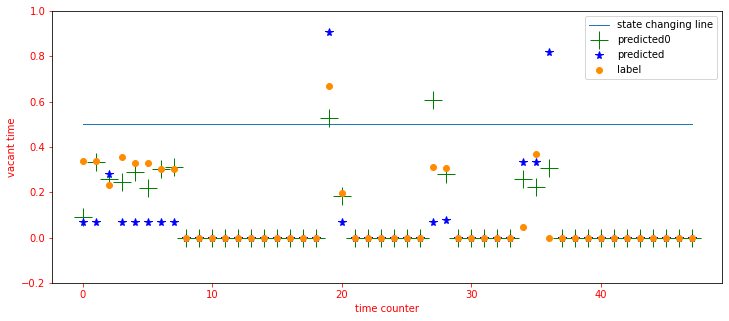

0.8944913105511522
0.8967639158235102


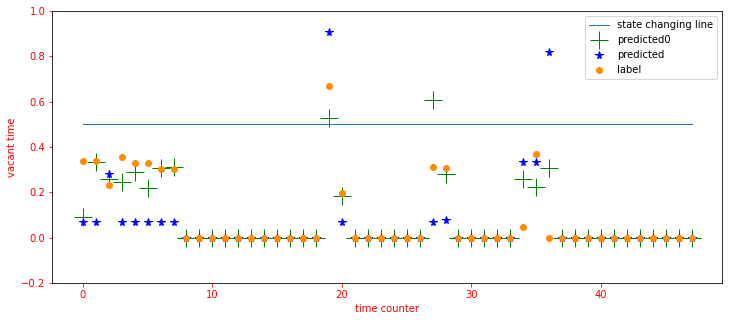

0.8944913105511522
0.8967639158235102


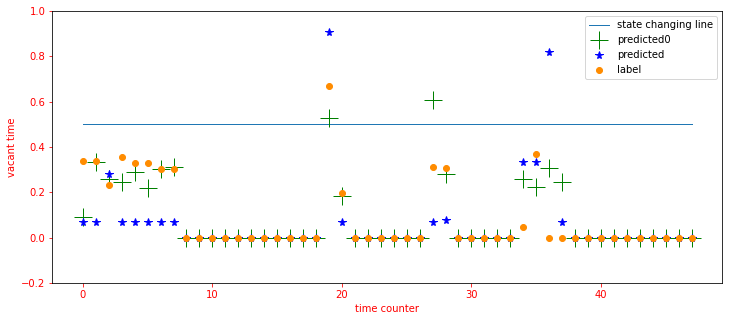

0.8906349417529522
0.8914223019134286


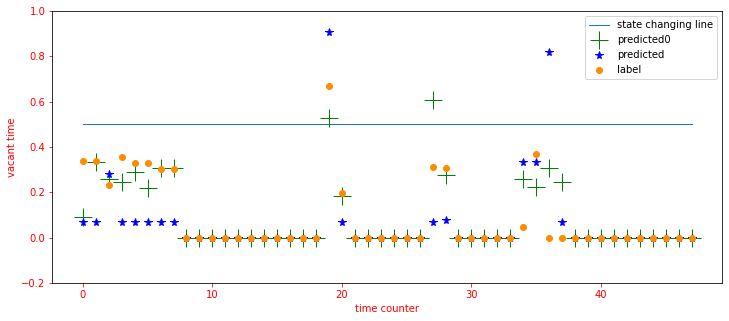

0.8891474245700258
0.8914223019134286


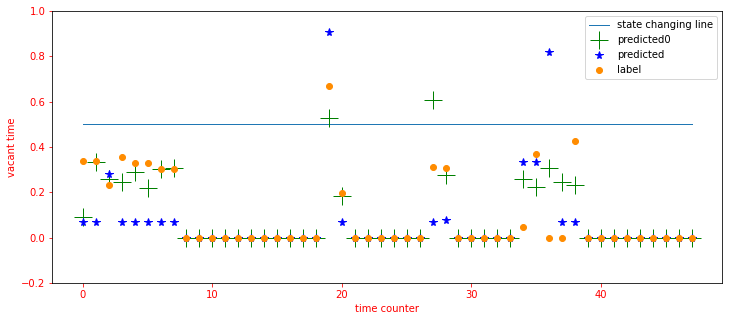

0.8803960568181886
0.8837512162908595


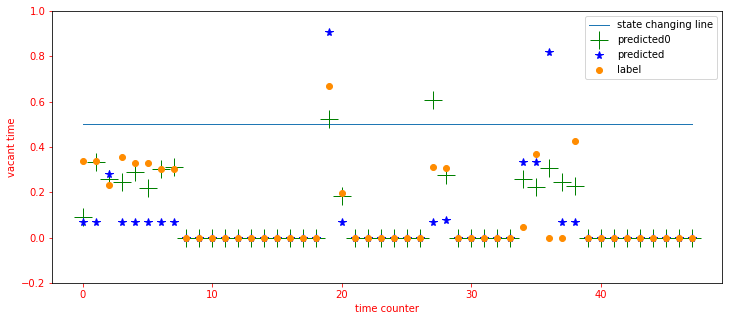

0.8803960568181886
0.8837512162908595


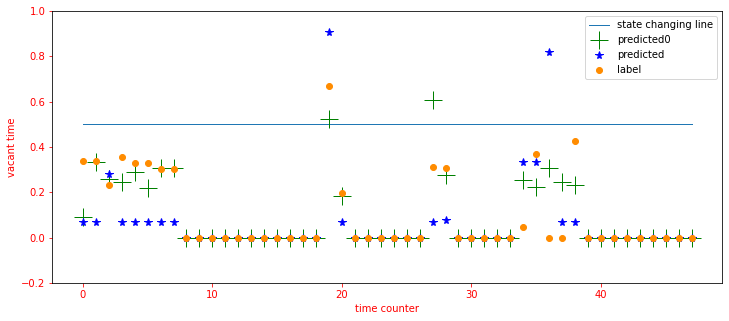

0.8817898929669699
0.8837512162908595


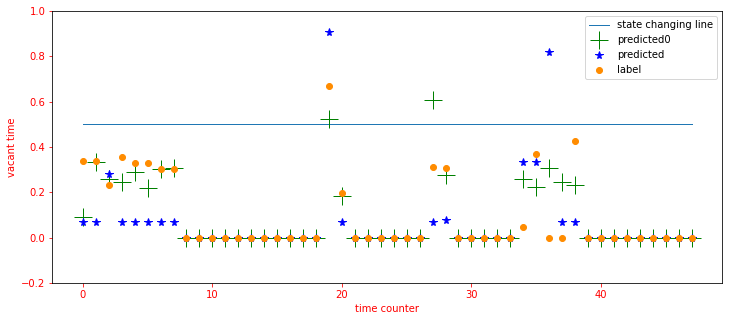

0.8803960568181886
0.8837512162908595


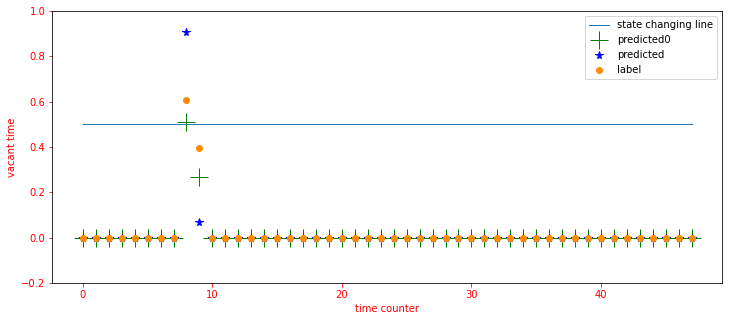

1.0
1.0


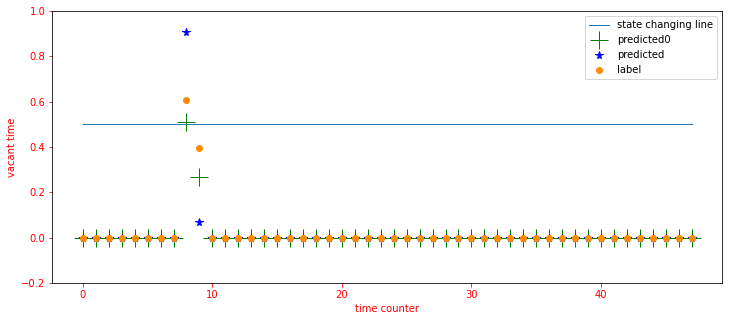

1.0
1.0


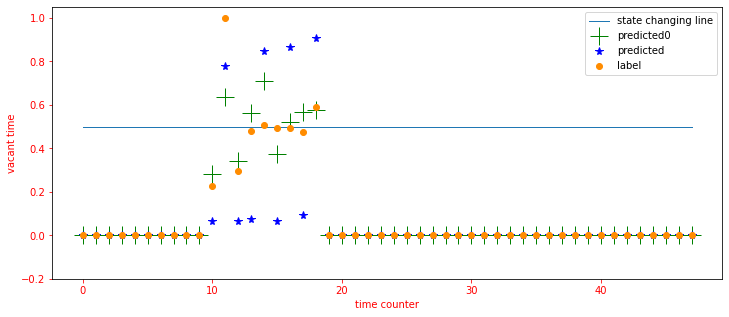

0.9221340715891073
0.8978416627064513


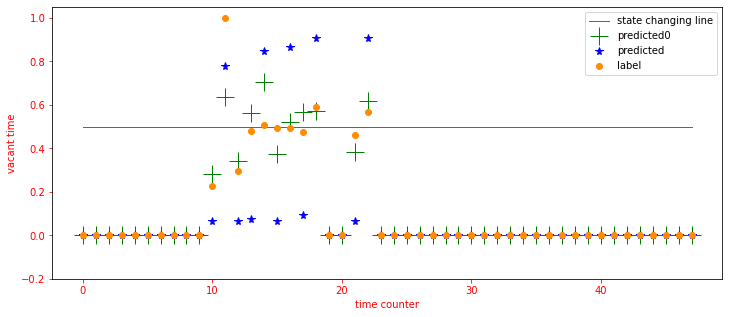

0.928778581109113
0.9026618345358027


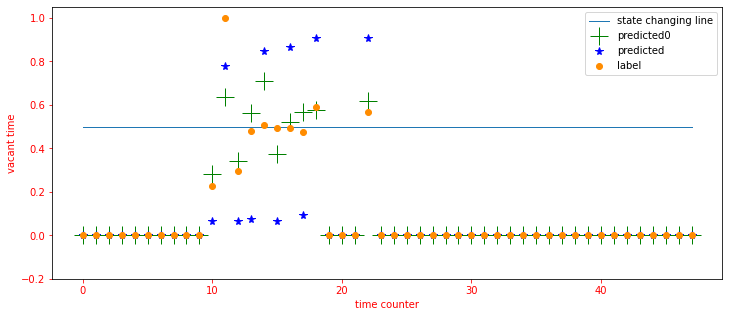

0.9254801998260853
0.8987208344111468


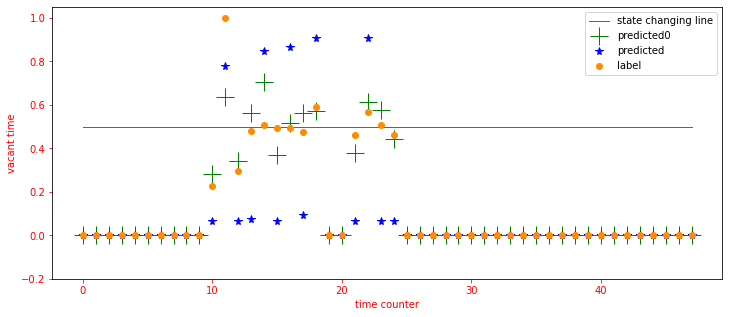

0.9337299398138699
0.9092932131225147


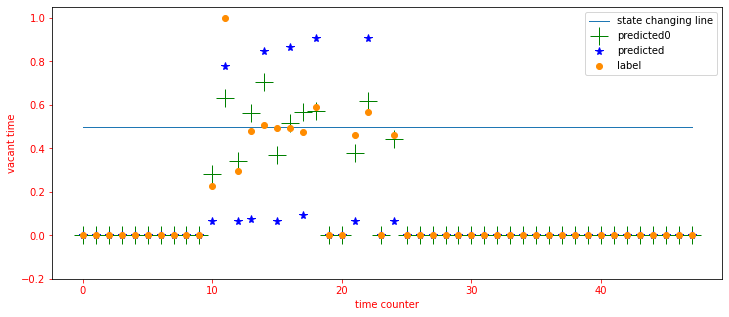

0.9317058021004386
0.9062500136949527


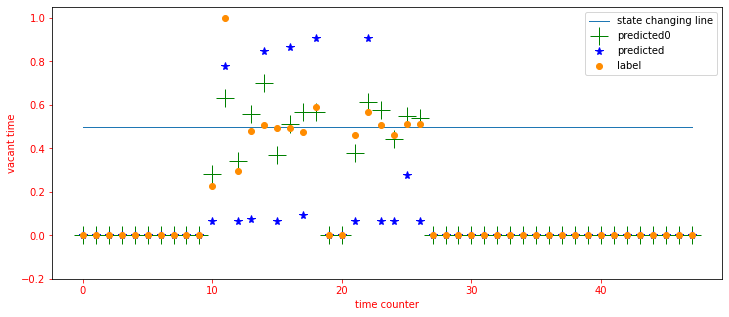

0.9383179598537784
0.9159701557311544


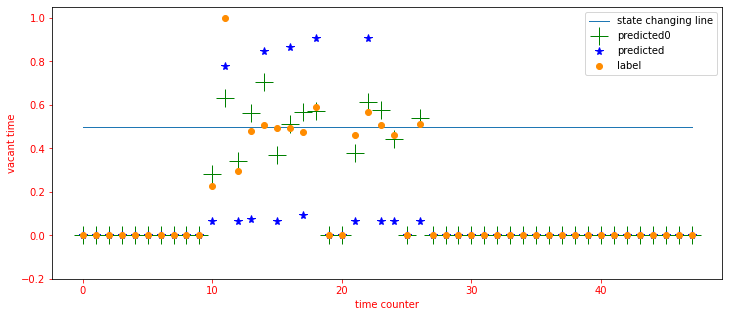

0.93611467140877
0.9119990517214936


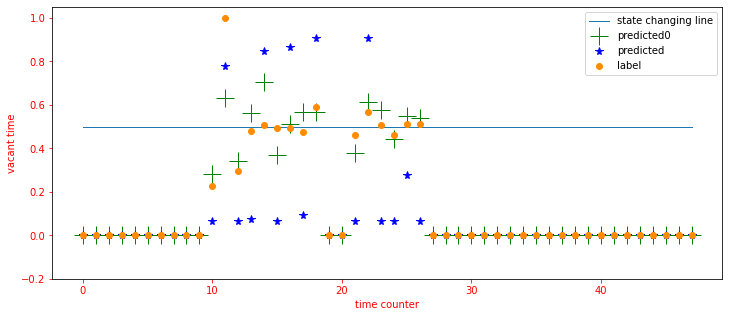

0.9383179598537784
0.9159701557311544


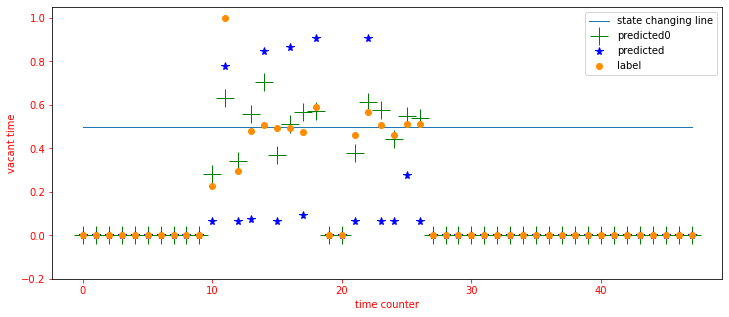

0.9383179598537784
0.9159701557311544


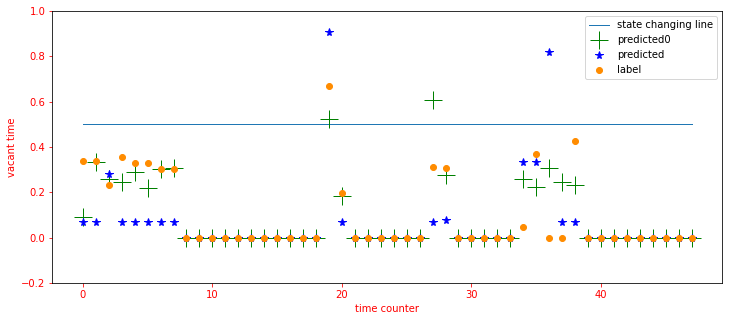

0.8803960568181886
0.8837512162908595


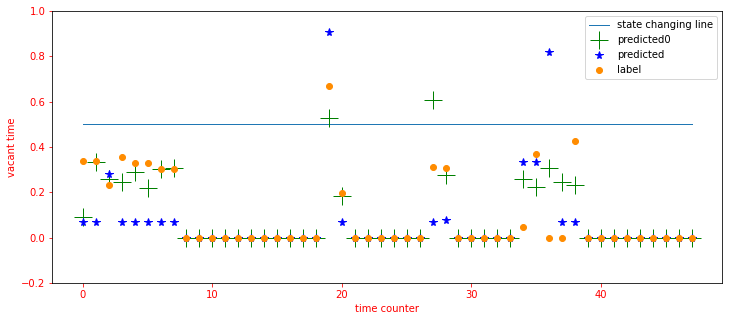

0.8803960568181886
0.8837512162908595


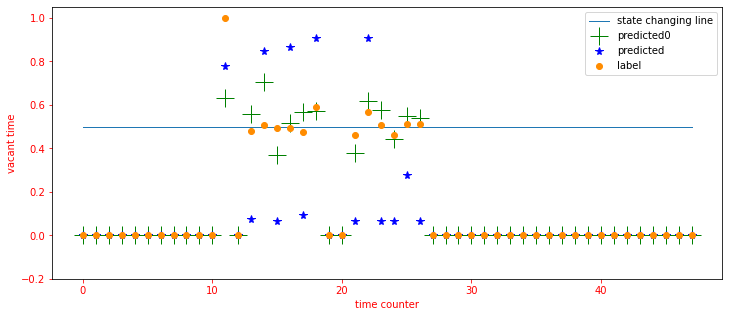

0.9357859007307064
0.9152814400535992


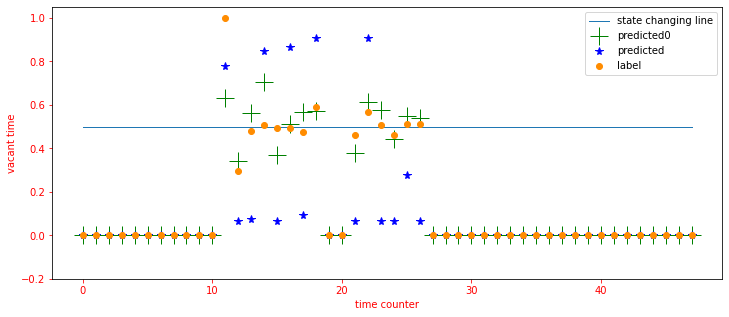

0.9372618181938662
0.9160761307738148


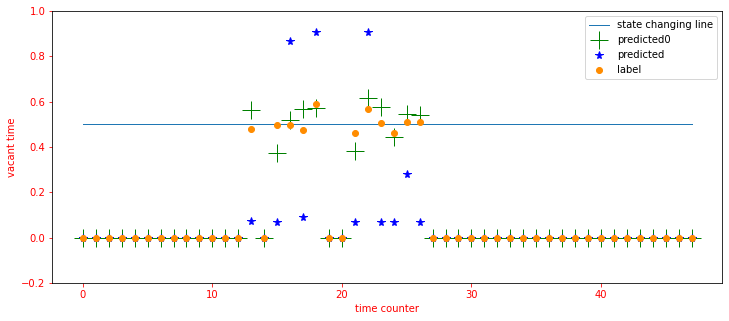

0.9890422208869789
0.9951434837791142


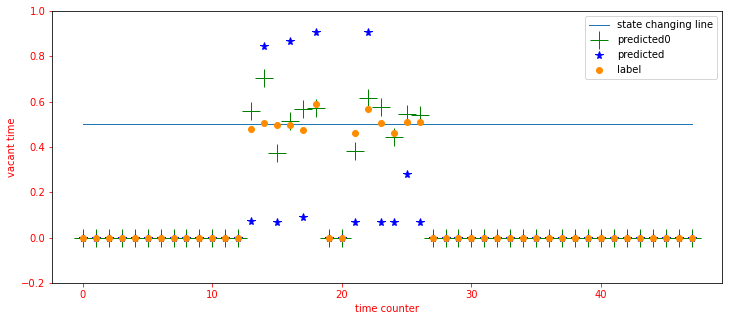

0.9793690232929156
0.9955859956243671


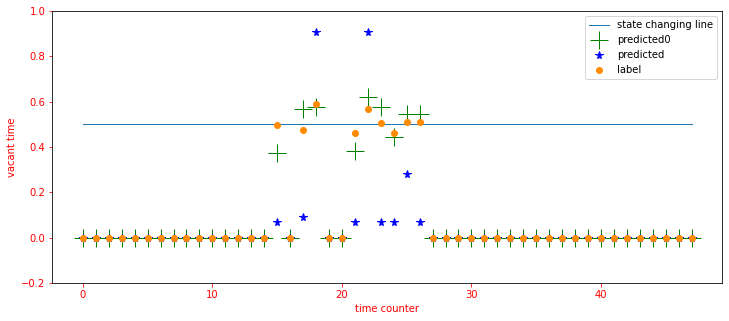

0.9886529976028431
0.9952347774982322


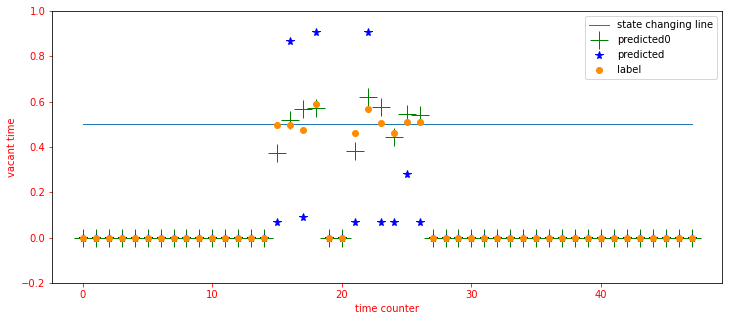

0.989277259515223
0.9952841769826476


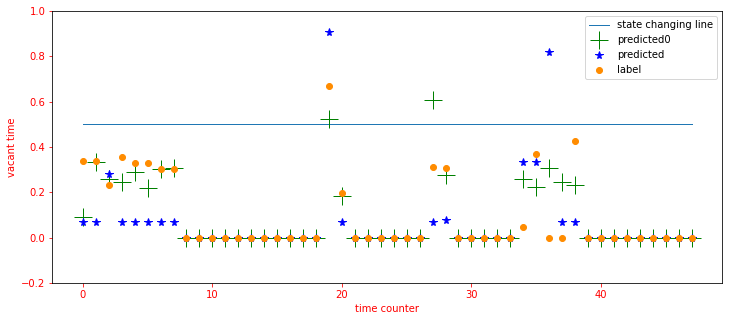

0.8803960568181886
0.8837512162908595


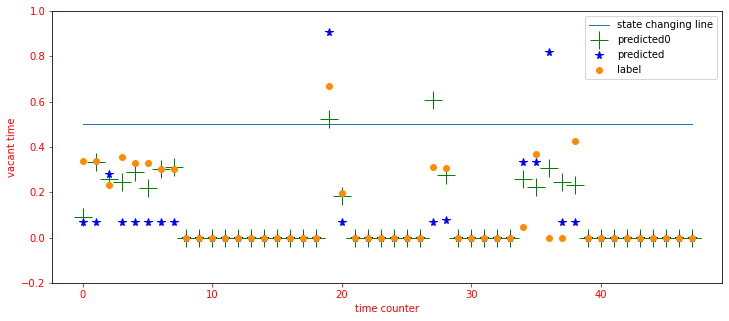

0.8803960568181886
0.8837512162908595


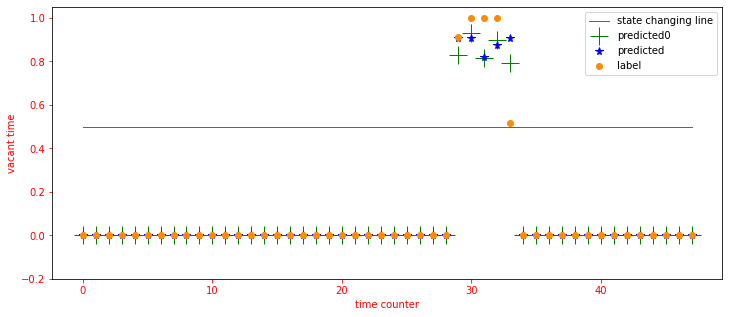

0.997814906665411
0.9336115492233035


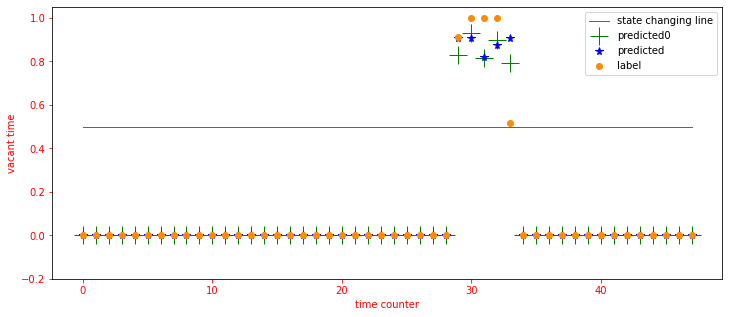

0.997814906665411
0.9336115492233035


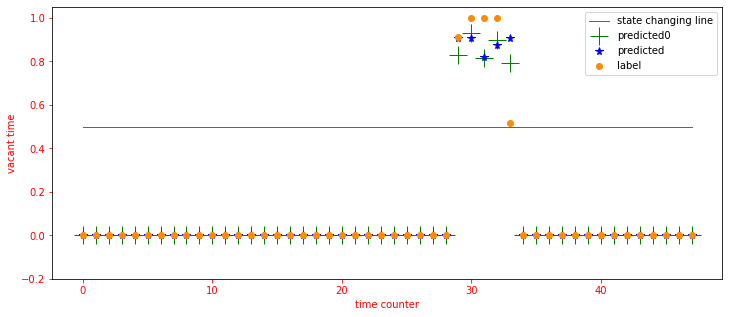

0.997814906665411
0.9336115492233035


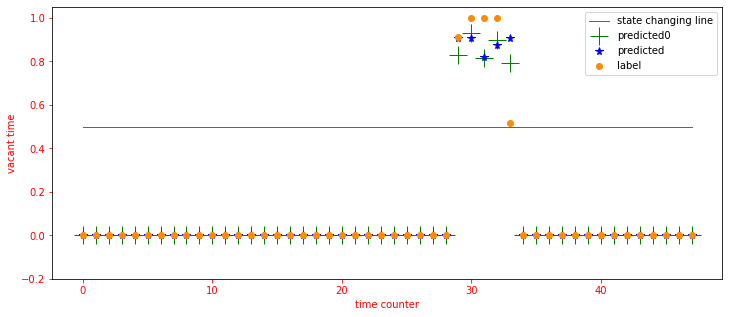

0.997814906665411
0.9336115492233035


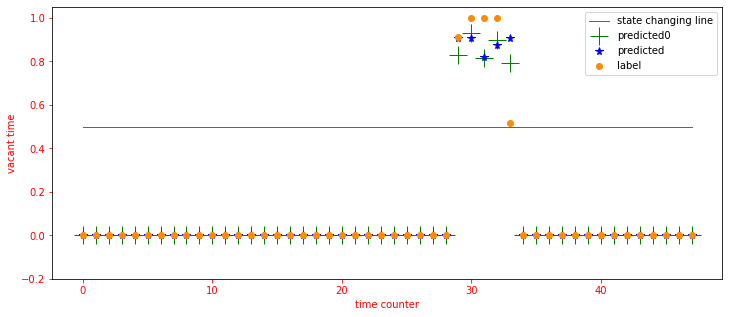

0.997814906665411
0.9336115492233035


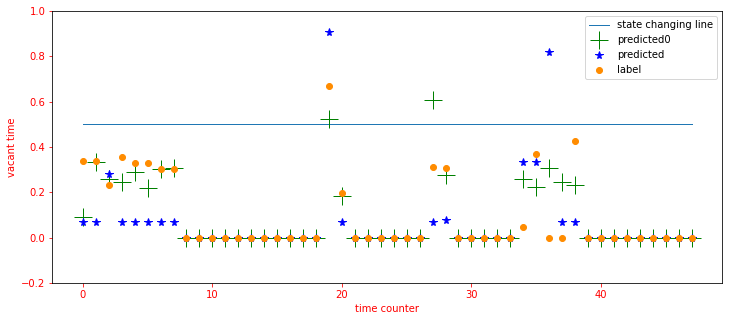

0.8803960568181886
0.8837512162908595


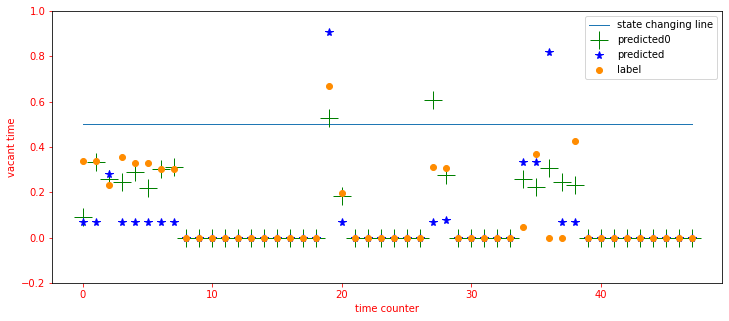

0.8803960568181886
0.8837512162908595


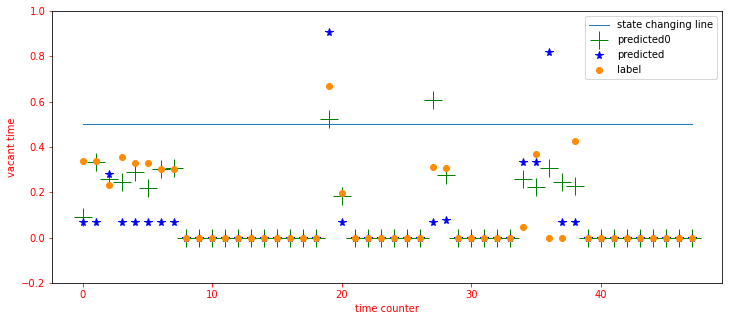

0.8803960568181886
0.8837512162908595


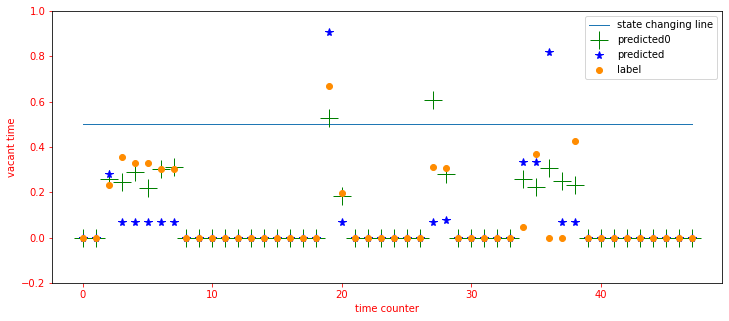

0.8653185462018643
0.8806599236362477


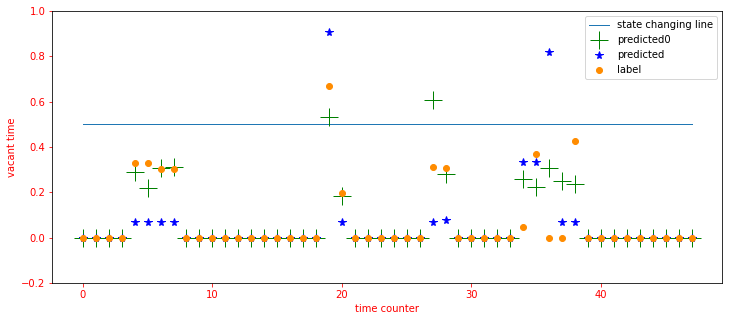

0.8625546949386643
0.8825630325078073


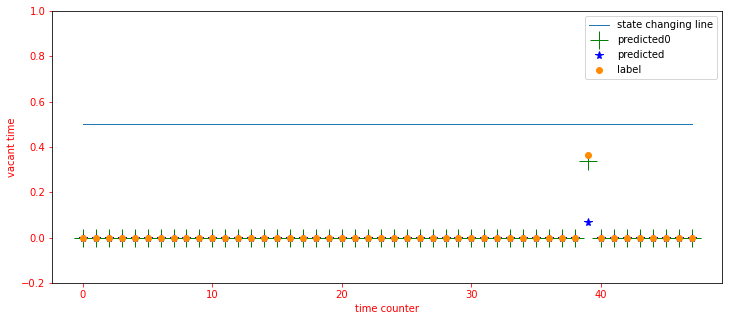

1.0
1.0


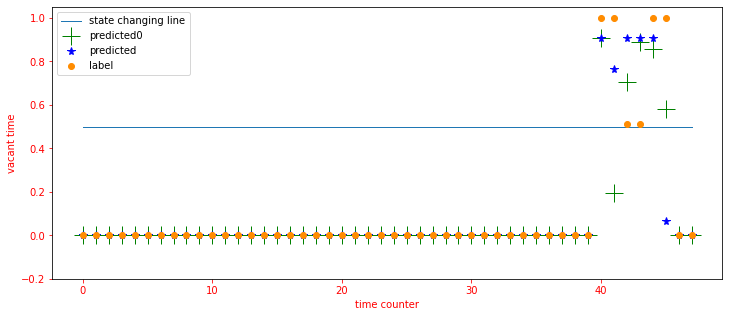

0.9469314805207047
0.9104141787557657


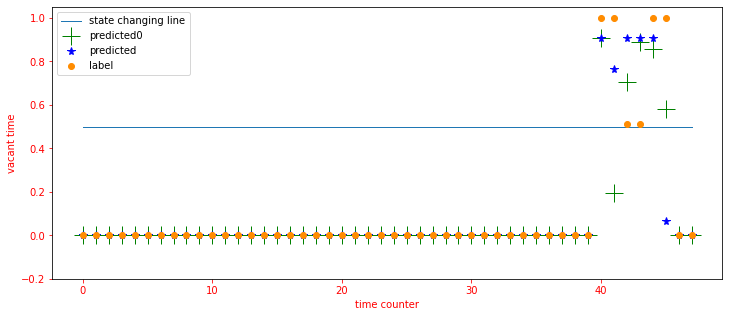

0.9469314805207047
0.9104141787557657


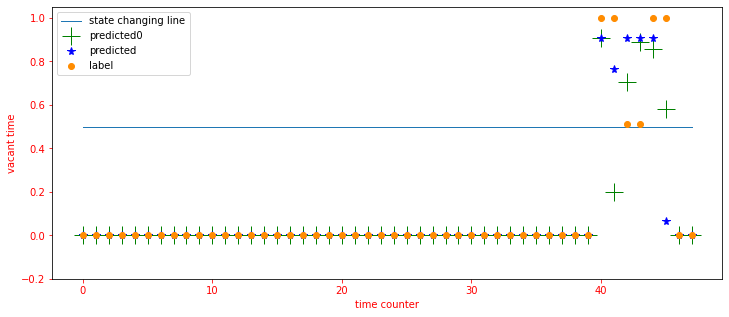

0.9469314805207047
0.9104141787557657


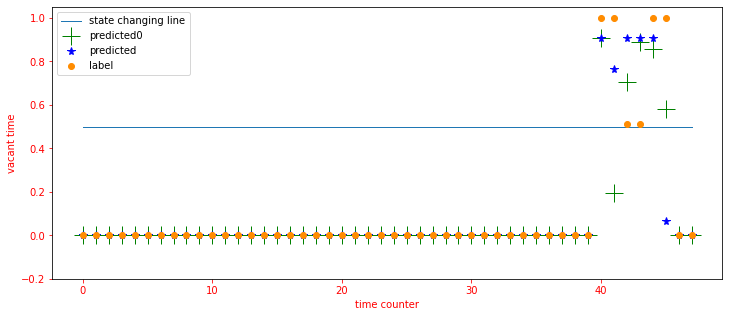

0.9469314805207047
0.9104141787557657


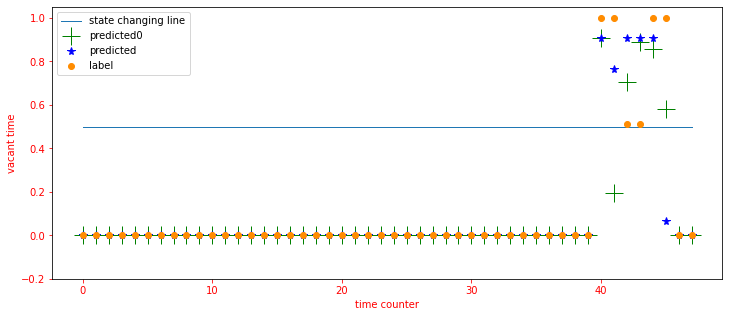

0.9469314805207047
0.9104141787557657


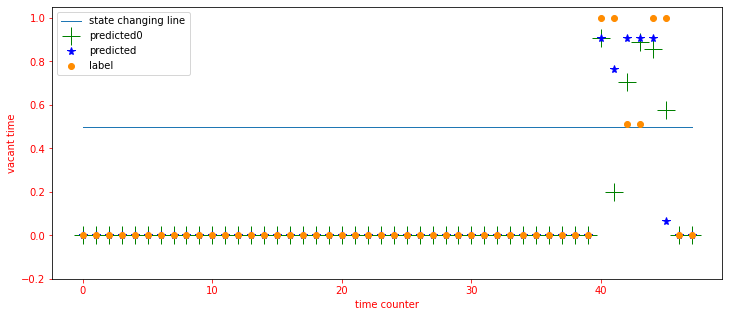

0.9469314805207047
0.9104141787557657


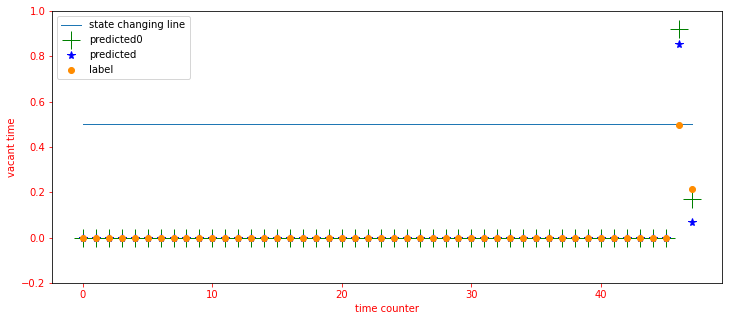

1.0
1.0


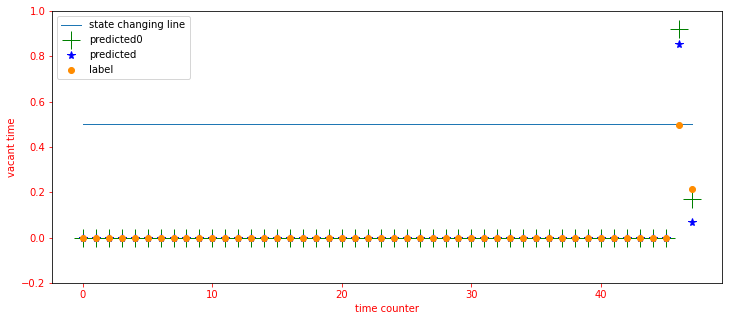

1.0
1.0


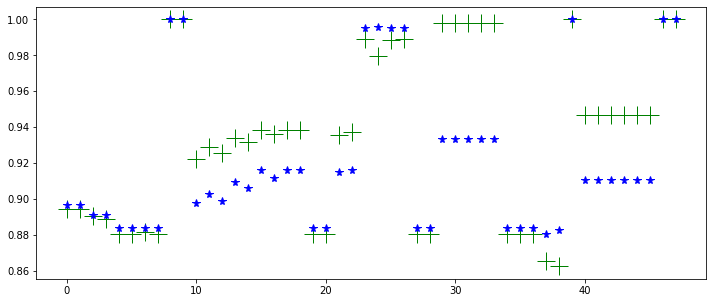

In [ ]:
a =80
proposed_list = []
fm_list = []
for i in range(48):
  x = np.arange(48)
  y_ticks = np.arange(-0.2,1.2,step=0.2)
  y = 0.5*np.ones_like(x)
  py0 = preds_HCGtest[a,i,:]
  py1 = preds_F[a,i,:] 
  py2 = target_HCGtest[a,i,:] 
  fig,ax=plt.subplots()
  plt.plot(x, y, label = 'state changing line', linewidth = 1)
  plt.plot(x,py0, '+',color='g',markersize=18.,label = 'predicted0')
  plt.plot(x,py1, '*',color='b',markersize=8.,label = 'predicted')
  plt.plot(x,py2, 'o',color='darkorange',markersize=6.,label = 'label')

  plt.rcParams['figure.figsize'] = (12,5)
  plt.xlabel('time counter')
  plt.ylabel('vacant time')
  plt.yticks(y_ticks)
  plt.legend()
  plt.tick_params(axis='x',colors='red')
  plt.tick_params(axis='y',colors='red')
  ax.xaxis.label.set_color('red')
  ax.yaxis.label.set_color('red')
  plt.show()

  n_proposed = ndcg_score(target_HCGtest[a,i:(i+1)],preds_HCGtest[a,i:(i+1)])
  n_fm = ndcg_score(target_HCGtest[a,i:(i+1)],preds_F[a,i:(i+1)])
  print(n_proposed)
  print(n_fm)
  proposed_list.append(n_proposed)
  fm_list.append(n_fm)

x = np.arange(48)
y_ticks = np.arange(0.6,1.0,step=0.1)

py0 = proposed_list
py1 = fm_list

fig,ax=plt.subplots()
plt.plot(x,py0, '+',color='g',markersize=18.,label = 'predicted0')
plt.plot(x,py1, '*',color='b',markersize=8.,label = 'predicted')

In [ ]:
aaa = 189
ndcg = tfr.keras.metrics.NDCGMetric(topn=111)
n_proposed = ndcg_score(target_HCGtest[aaa],preds_HCGtest[aaa])
n_fm = ndcg_score(target_HCGtest[aaa],preds_F[aaa])
print(n_proposed)
print(n_fm)
aaa = 126
ndcg = tfr.keras.metrics.NDCGMetric(topn=1)
n_proposed = ndcg_score(target_HCGtest[aaa],preds_HCGtest[aaa])
n_fm = ndcg_score(target_HCGtest[aaa],preds_F[aaa])
print(n_proposed)
print(n_fm)
aaa = 127
ndcg = tfr.keras.metrics.NDCGMetric(topn=1)
n_proposed = ndcg_score(target_HCGtest[aaa],preds_HCGtest[aaa])
n_fm = ndcg_score(target_HCGtest[aaa],preds_F[aaa])
print(n_proposed)
print(n_fm)

0.9274625359495601
0.816942159237184
0.9901137568641438
0.9875324870650322
0.9941453317843032
0.9850981364743111


In [ ]:
preds_HCGtest[122].shape

torch.Size([48, 48])

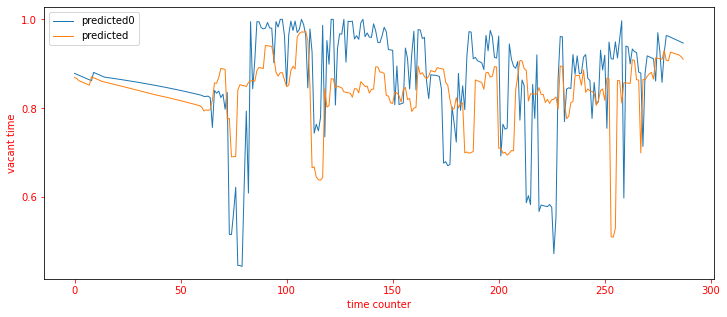

0.8638650053714518
0.8383577513280186


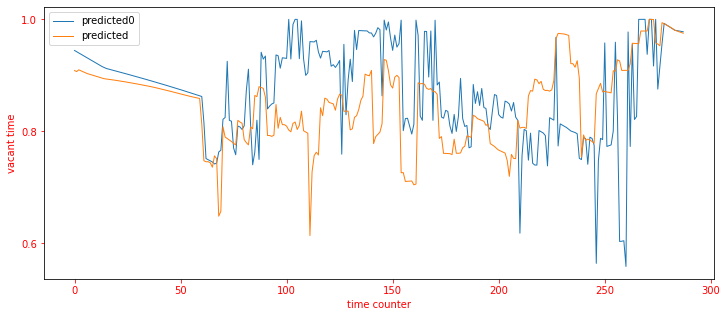

0.8721376722100356
0.8507654065412102


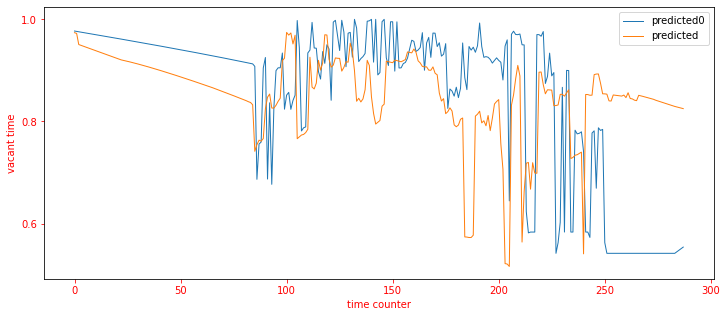

0.8539457381117609
0.853353951764396


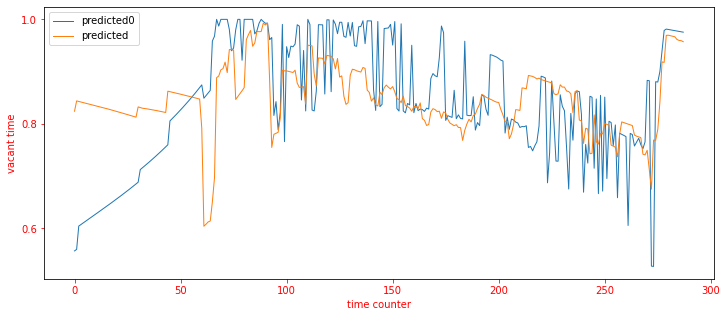

0.8415154899722856
0.8453991857690804


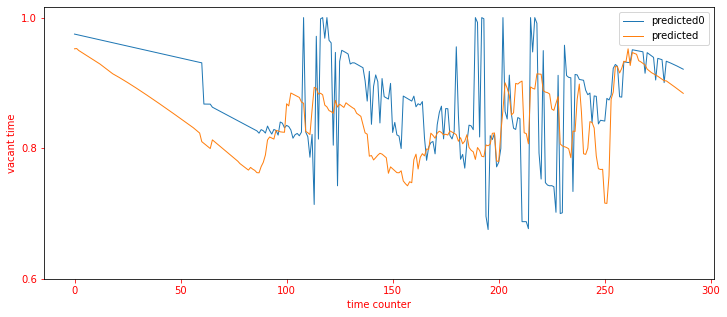

0.8838748019301218
0.8466406387550075


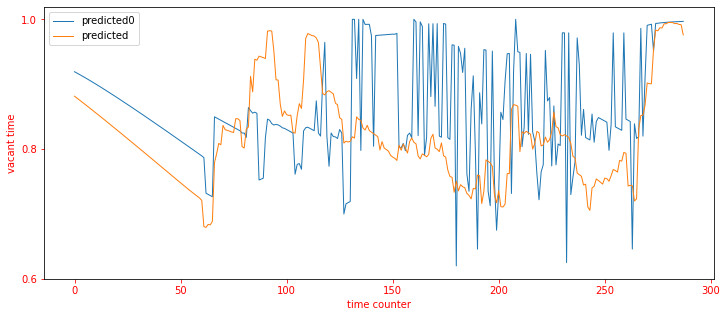

0.8626150043699384
0.8209441657663681


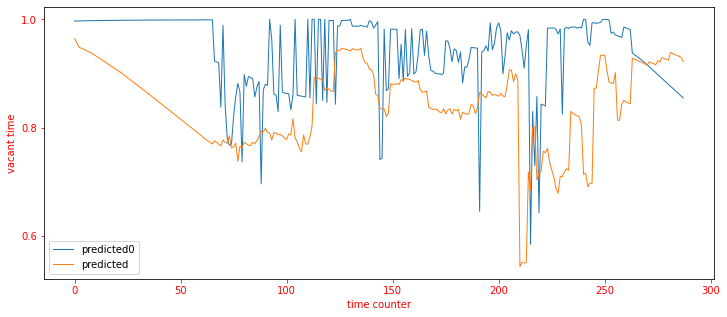

0.9415434813184551
0.8427468644619025


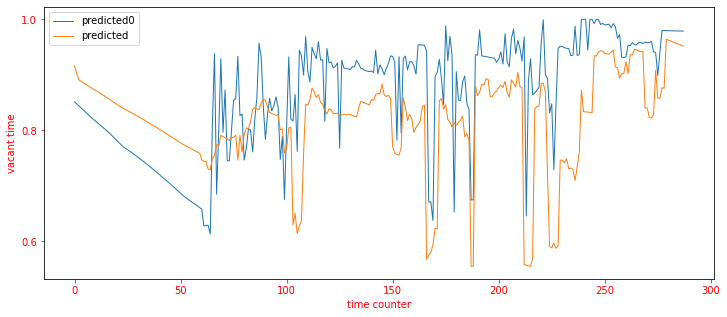

0.8674989378706088
0.8195390177708679


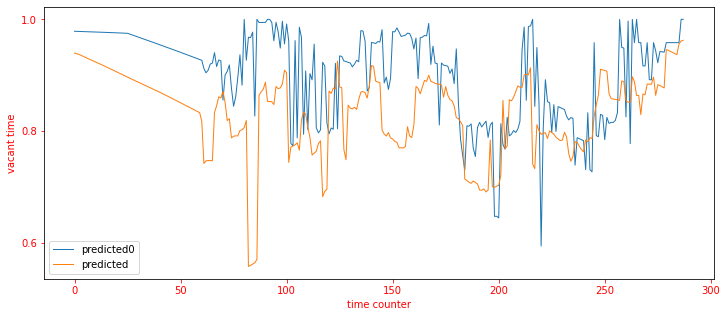

0.9047967054352983
0.835014873571573


ValueError: ignored

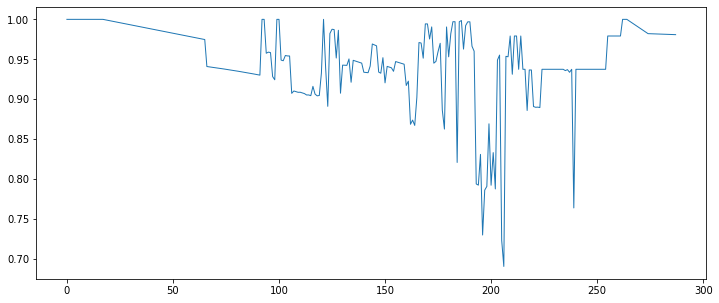

In [ ]:
day = 10
for i in range(day):  
  
  left = 288 * i
  right = 288 * (i+1)
  x = np.arange(288)
  y_ticks = np.arange(0.6,1.2,step=0.2)
  # y = 0.5*np.ones_like(x)
  py0 = pndcg[left:right]
  py1 = fmndcg[left:right] 

  fig,ax=plt.subplots()
  # plt.plot(x, y, label = 'state changing line', linewidth = 1)
  # plt.plot(x,py0, '+',color='g',markersize=8.,label = 'predicted0')
  # plt.plot(x,py1, '*',color='b',markersize=8.,label = 'predicted')
  plt.plot(x,py0, label = 'predicted0', linewidth = 1)
  plt.plot(x,py1, label = 'predicted', linewidth = 1)

  plt.rcParams['figure.figsize'] = (12,5)
  plt.xlabel('time counter')
  plt.ylabel('vacant time')
  plt.yticks(y_ticks)
  plt.legend()
  plt.tick_params(axis='x',colors='red')
  plt.tick_params(axis='y',colors='red')
  ax.xaxis.label.set_color('red')
  ax.yaxis.label.set_color('red')
  plt.show()

  print(py0.mean())
  print(py1.mean())

pr:  [0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.932873574957411, 0.9195614332554821, 0.9062389203719947, 0.9345464365296904, 0.9011097702634707, 0.8395730459372461, 0.860977407489507, 0.8317971946356483, 0.8271748802639903, 0.9133829155952841, 0.9141530229406568, 0.9289383856185603, 0.899855407203304, 0.8945722709307011, 0.9131698651496558, 0.9310930268943736, 0.7356165326307792, 0.7306295597631355, 0.7543715914619821, 0.7111783327627541, 0.7657324366726804, 0.7382578362719814, 0.7824413412790383, 0.8281027265756592, 0.8272516412985652, 0.8158016458655964, 0.964097344802688, 0.

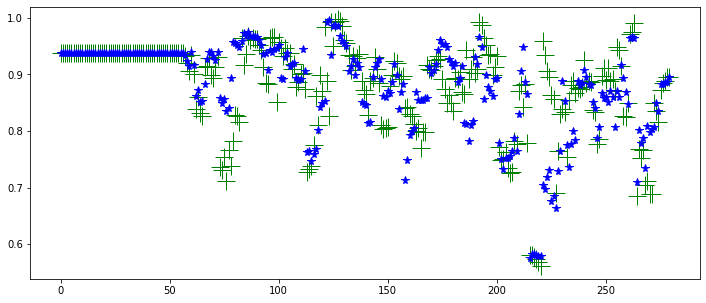

In [ ]:
ndcg = tfr.keras.metrics.NDCGMetric(topn=1)

left=0
right=280

proposed_list = []
fm_list = []

for i in range(left,right):

  proposed = ndcg_score(target_HCGtest[i], preds_HCGtest[i])
  fm = ndcg_score(target_HCGtest[i], preds_F[i])
  proposed_list.append(proposed)
  fm_list.append(fm)

print("pr: ",proposed_list)
print("fm: ",fm_list)

x = np.arange(right-left)
y_ticks = np.arange(0.6,1.0,step=0.1)

py0 = proposed_list
py1 = fm_list

fig,ax=plt.subplots()
plt.plot(x,py0, '+',color='g',markersize=18.,label = 'predicted0')
plt.plot(x,py1, '*',color='b',markersize=8.,label = 'predicted')

pr:  [0.66461813, 0.58959496]
fm:  [0.60314244, 0.5671962]


([<matplotlib.axis.YTick at 0x7f9afe4ad490>,
 <a list of 6 Text major ticklabel objects>)

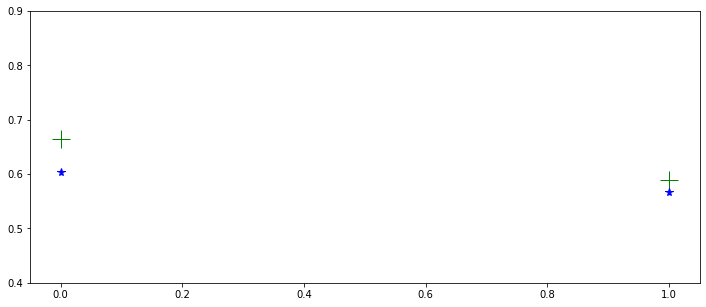

In [ ]:
ndcg = tfr.keras.metrics.NDCGMetric(topn=1)

left=2198
right=2200

proposed_list = []
fm_list = []

for i in range(left,right):

  proposed = ndcg(target_HCGtest[i], preds_HCGtest[i])
  fm = ndcg(target_HCGtest[i], preds_F[i])
  proposed_list.append(proposed.numpy())
  fm_list.append(fm.numpy())

print("pr: ",proposed_list)
print("fm: ",fm_list)

x = np.arange(right-left)
y_ticks = np.arange(0.4,1.0,step=0.1)

py0 = proposed_list
py1 = fm_list

fig,ax=plt.subplots()
plt.plot(x,py0, '+',color='g',markersize=18.,label = 'predicted0')
plt.plot(x,py1, '*',color='b',markersize=8.,label = 'predicted')
plt.yticks(y_ticks)

In [ ]:
y_true = [[0., 1., 1., 0, 0, 0]]
y_pred = [[3., 1., 2., 0, 0, 0]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()





0.6934264

In [ ]:
y_true = preds_HCGtest[aaa,:1]
y_pred = target_HCGtest[aaa,:1]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

0.8773679

In [ ]:
target_HCGtest[aaa,:1]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
ndcg = tfr.keras.metrics.NDCGMetric(topn=6)
y_true = [[13.7497, 11.7108, 11.2238, 11.9124, 11.2053, 10.9301, 11.2279, 11.9598,
         -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000, -0.0000,  0.0000, 11.7174, 11.3170, -0.0000, -0.0000,  0.0000,
         -0.0000, -0.0000,  0.0000, 13.7960, 11.2675,  0.0000, -0.0000, -0.0000,
         -0.0000,  0.0000, 12.0390, 11.1710, 11.4119,  0.0000,  0.0000, -0.0000,
          0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000]]
y_pred = [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]


# y_true_sort = np.argsort(y_true)
# y_pred_sort = np.argsort(y_pred)
ndcg(y_pred, y_true).numpy()

1.0

In [ ]:
y_true_sort




array([[23, 46, 24, 25, 26, 29, 30, 31, 32, 22, 33, 38, 39, 40, 41, 42,
        43, 44, 45, 37, 21, 47, 10, 18, 17, 16, 15, 14, 13, 12, 11,  8,
         9,  5, 35,  4,  2,  6, 28, 20, 36,  1, 19,  3,  7, 34,  0, 27]])

In [ ]:
y_pred_sort

array([[23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 24, 35, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 36, 46, 47, 21,  1,  2,  3,  4,  5,  6,  7,
         8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 27,  0]])